# Neural Networks with Pytorch

This notebook implements the utilities from `fullyconnected_neuralnetwork.py` in an easy example.
All in all, the basic use of Pytorch is showcased: dataset loading, model definition, model training, image inferece & visualization.
The notebook is divided in 4 sections:

1. Tensors: basic usage of the tensor structure is explained
2. Main Exemplary Application: `fullyconnected_neuralnetwork.py` is employed in an easy application
3. Custom datasets: how to prepare our images to generate a dataset
4. Additional features: manually defined networks, weight & bias access

## 1. Tensors

To have an idea of the concept of tensor structures, see `tensors.py`.

## 2. Main Exemplary Application
In this section, the generic utility script for neural network training and use `fullyconnected_neuralnetwork.py` is employed in an easy application in which the Fashion-MNIST dataset is used. What is done:
- Dataset is loaded and briefly checked
- Network is created
- Network is trained
- Network is saved and loaded again
- Network is inferred


In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper_nn as hnn
import fullyconnected_neuralnetwork as fc_nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# LOAD DATASET: example, Fashion-MNIST (28x28 pixels, 1 channel, 10 classes)
transform = transforms.Compose([transforms.ToTensor(), # grayvalues mapped to [0,1]
                                transforms.Normalize((0.5,), (0.5,))]) # grayvalues mapped to [-1,1]
trainset = datasets.FashionMNIST('../../../DL_PyTorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.FashionMNIST('../../../DL_PyTorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


<AxesSubplot:>

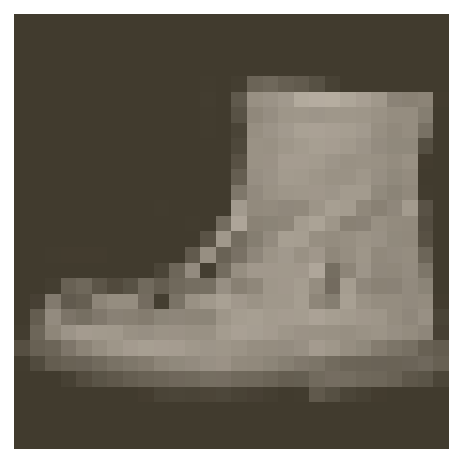

In [3]:
# CHECK DATSET
image, label = next(iter(trainloader))
print(trainset.classes)
hnn.imshow(image[0,:])

In [4]:
# Have a clear idea of the image tensor shape
# [batch_size, channels, width, height]
image.shape

torch.Size([64, 1, 28, 28])

In [5]:
# CREATE NETWORK: basically, we need:
# 1. model: network
# 2. loss function: criterion
# 3. weight update strategy: optimizer
#
#input_size = 1*28*28 = 728
input_size = image.size()[1]*image.shape[2]*image.shape[3]
#output_size = 10
output_size = len(trainset.classes)
# Select desired number of hidden layers and their sizes
hidden_sizes = [512, 256, 128]
model = fc_nn.Network(input_size, output_size, hidden_sizes)
criterion = nn.NLLLoss() # Alternatives: nn.CrossEntropyLoss(), nn.MSELoss()
# Loss could be: MSE (Mean Square Error), CrossEntropy, NLL (Negative Log Likelihood)
# NLL == CrossEntropy if NLL is applied after LogSoftmax
# MSE makes sense for continuous predictions (regression)
# CrossEntroy (and NLL) make sense for categorical (class) predictions
optimizer = optim.Adam(model.parameters(), lr=0.001) # Alternatives: optim.SGD()

In [6]:
# TRAIN
fc_nn.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Training on cpu
Epoch: 1/2..  Training Loss: 1.676..  Test Loss: 0.981..  Test Accuracy: 0.635
Epoch: 1/2..  Training Loss: 1.065..  Test Loss: 0.760..  Test Accuracy: 0.703
Epoch: 1/2..  Training Loss: 0.882..  Test Loss: 0.685..  Test Accuracy: 0.749
Epoch: 1/2..  Training Loss: 0.797..  Test Loss: 0.676..  Test Accuracy: 0.741
Epoch: 1/2..  Training Loss: 0.762..  Test Loss: 0.599..  Test Accuracy: 0.770
Epoch: 1/2..  Training Loss: 0.714..  Test Loss: 0.606..  Test Accuracy: 0.770
Epoch: 1/2..  Training Loss: 0.694..  Test Loss: 0.573..  Test Accuracy: 0.782
Epoch: 1/2..  Training Loss: 0.676..  Test Loss: 0.559..  Test Accuracy: 0.789
Epoch: 1/2..  Training Loss: 0.662..  Test Loss: 0.548..  Test Accuracy: 0.788
Epoch: 1/2..  Training Loss: 0.658..  Test Loss: 0.531..  Test Accuracy: 0.805
Epoch: 1/2..  Training Loss: 0.627..  Test Loss: 0.533..  Test Accuracy: 0.803
Epoch: 1/2..  Training Loss: 0.610..  Test Loss: 0.522..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.647..

In [7]:
# SAVE
filename = 'my_model_checkpoint.pth'
fc_nn.save_model(filename, model, input_size, output_size, hidden_sizes)

In [8]:
# LOAD
filename = 'my_model_checkpoint.pth'
model = fc_nn.load_model(filename)
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


torch.Size([1, 28, 28])
torch.Size([64, 1, 28, 28])


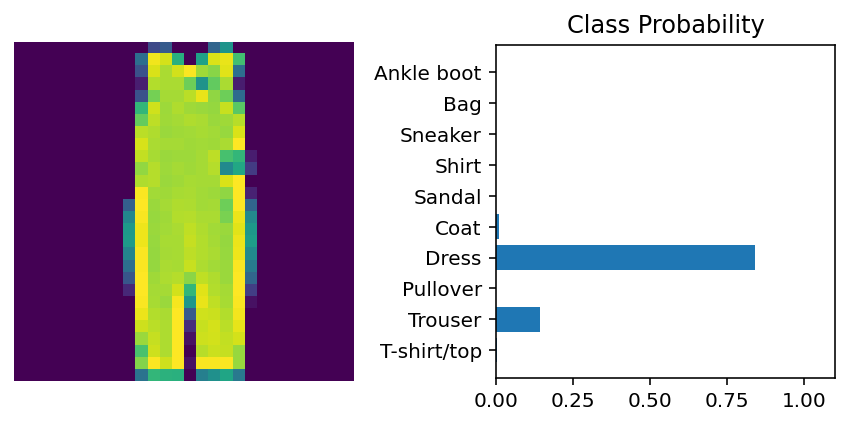

In [18]:
# INFER & VISUALIZE
model.eval()
images, labels = next(iter(testloader))
img = images[0] # Take one image from batch
print(img.shape) # [1, 28, 28]
print(images.shape) # [64, 1, 28, 28]
# Images can be flattened with .view()
img = img.view(1, images.shape[2]*images.shape[3]) # Note: visualization for one channel
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)
hnn.view_classify(img.view(1, 1, images.shape[2], images.shape[3]), ps, trainset.classes)
#hnn.view_classify(images[0], ps, trainset.classes)

## 3. Custom Datasets

We might want to create our own dataset from images. This section shows how this works. There are 3 elements to take into account:
- The folder which contains the images from which the **dataset** is constructed: `datasets.ImageFolder()`
- The preprocessing **transformations** we apply to the images of the dataset: `transforms.Compose()`
- The **dataset loader** which delivers the transformed and preprocessed batch from the dataset: `torch.utils.data.DataLoader()`

Additionally, note that `datasets.ImageFolder()` expects the images to be structured class folders:
```bash
    dataset/
        train/
            cats/
                cat_01.jpeg
                cat_02.jpeg
                ...
            dogs/
        test
            cats/
            dogs/
```
If not, we might have an Excel sheet or similar that annotates the classes of each images instead; in that case, we need to write a script that re-organizes the images into that folder structure. See file `organize_dataset.py` from `../pytorch_example_01/`

In [19]:
import torch
from torchvision import datasets, transforms
import helper_nn as hnn

In [20]:
# Define image folder: inside data_dir, each class should have a subfolder, eg
# path/train/dog, path/train/cat...
data_dir = '../../../DL_PyTorch/Cat_Dog_data/train'
# Compose transforms: Select transformations to squentially apply to dataset
# Resize: w (x h)
# CenterCrop: center crop with w (x h) - many pre-trained models accept 224x224 inputs
# Grayscale: convert to one channel
# We can also apply transformations for data augmentation: RandomRotation, RandomResizedCrop, RandomHorizontalFlip
# ToTensor: convert into a pytorch tensor and map grayvalues to [0,1]
# Normalize: list of means & list of stds passed, so that
#   input[channel] = (input[channel] - mean[channel]) / std[channel]
#   with transfer learning, we need to use the narmoalization that was used in the pre-training, eg:
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#   this normalization maps the pixels to [-1,1]
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
transform = transforms.Compose([transforms.Resize(125),
                                 transforms.CenterCrop(124),
                                 transforms.Grayscale(num_output_channels=3),                                
                                 transforms.ToTensor()
                               ])
# Specify the ImageFolder object
dataset = datasets.ImageFolder(data_dir, transform=transform)
# Create the DataLoader from ImageFolder: DataLoader is an iterator of the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [21]:
# Images from dataset can be extracted in two main ways:
# 1) Looping through it, get a batch on each loop 
for images, labels in dataloader:
    break
# 2) # Get one batch
images, labels = next(iter(dataloader))

In [22]:
# Have clear size of images
images.size()

torch.Size([64, 3, 124, 124])

In [23]:
labels.size()

torch.Size([64])

<AxesSubplot:title={'center':'Cat'}>

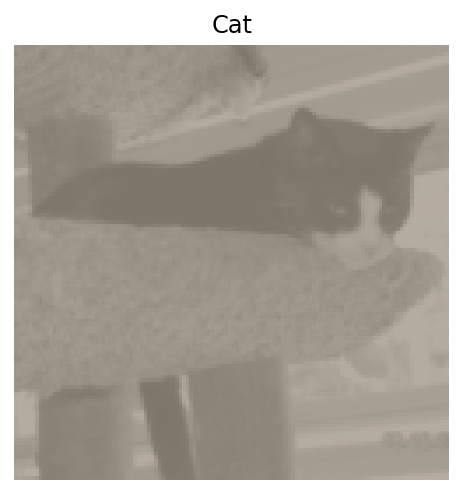

In [24]:
# Visualize first image of batch
title = 'Dog'
id = 4
if labels[id].item() == 0:
    title = 'Cat'
hnn.imshow(images[id,:], title=title)

## 4. Additional

This section covers some additional features that can be useful:
- Manual network/model definition using `nn.Sequential()` and further layers types, such as `Conv2d`, `MaxPool2d`
- Model layer bias & weight value access
- Visualize layers/filters and activation/feature maps

In [25]:
# It is also possible to create amodel with nn.Sequential()
input_size = 1*28*28
hidden_sizes = [128, 64]
output_size = 10
from collections import OrderedDict
new_model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
print(new_model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [26]:
# We can create many layers of different kind: Conv2d, MaxPool2d
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        # output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        self.conv1 = nn.Conv2d(1, 10, 3)
        # maxpool layer
        # pool with kernel_size=2, stride=2
        # after one pool 2d layer (2,2), (10, 26, 26) becomes (10, 13, 13)
        self.pool = nn.MaxPool2d(2, 2)
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        # output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        # final output
        return x

In [27]:
# instantiate your Net
net = Net()
# load the net parameters (stored before)
net.load_state_dict(torch.load('fashion_net_ex.pt'))
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [28]:
# We can read weights and biases of any layer
net.fc1.weight

Parameter containing:
tensor([[ 0.0138,  0.1262,  0.0322,  ...,  0.0379, -0.0297,  0.0297],
        [-0.0201, -0.0168, -0.0212,  ..., -0.0332, -0.0151,  0.0011],
        [ 0.0747, -0.0634,  0.0180,  ..., -0.0498,  0.0500, -0.0034],
        ...,
        [ 0.0277, -0.0099,  0.0451,  ...,  0.0861,  0.0105,  0.0380],
        [ 0.0731, -0.2071, -0.0436,  ...,  0.0360,  0.0640, -0.0616],
        [ 0.0577,  0.0463, -0.1177,  ..., -0.1626, -0.0488, -0.0393]],
       requires_grad=True)

In [29]:
net.fc1.bias

Parameter containing:
tensor([ 0.0508,  0.0108,  0.0123,  0.0156, -0.0403, -0.0183,  0.0456, -0.0545,
         0.0230,  0.3006, -0.0604,  0.0139,  0.0502,  0.1048, -0.0535,  0.0874,
         0.2944,  0.0573, -0.0078,  0.0011, -0.0270,  0.0649,  0.1205,  0.0332,
         0.0194,  0.0783, -0.0089,  0.0840,  0.0726, -0.0853,  0.0385, -0.0499,
         0.0561,  0.0240,  0.0105,  0.0674, -0.0038, -0.0023,  0.1902,  0.1427,
         0.0859, -0.0756,  0.0140,  0.1212,  0.0502, -0.1173,  0.0691,  0.1434,
         0.1188,  0.0543], requires_grad=True)

In [30]:
# We could set biases to all zeros
new_model.fc1.bias.data.fill_(0)
# We could sample from random normal (mean = 0) with standard dev = 0.01
new_model.fc1.weight.data.normal_(std=0.01)

tensor([[-3.2042e-03,  1.3179e-02,  2.7242e-04,  ...,  9.1395e-03,
         -7.7484e-03,  1.1524e-02],
        [-1.0116e-02, -5.2304e-03, -4.9503e-03,  ..., -4.0854e-03,
         -8.2211e-03, -3.9550e-03],
        [ 7.4910e-03,  2.4188e-03,  2.6855e-03,  ...,  9.9432e-03,
         -4.1407e-05, -5.9918e-03],
        ...,
        [ 5.9821e-03, -1.1743e-02,  7.8105e-03,  ..., -5.2032e-03,
          4.9520e-04, -3.1199e-03],
        [-7.4070e-04,  2.3898e-03, -9.1184e-03,  ..., -1.6281e-02,
          1.2267e-02,  2.2442e-03],
        [ 1.2917e-02, -6.3630e-04,  1.0664e-02,  ...,  9.6871e-03,
         -4.3283e-03, -1.5602e-02]])

### Layer/Filter Visualization

First convolutional layer


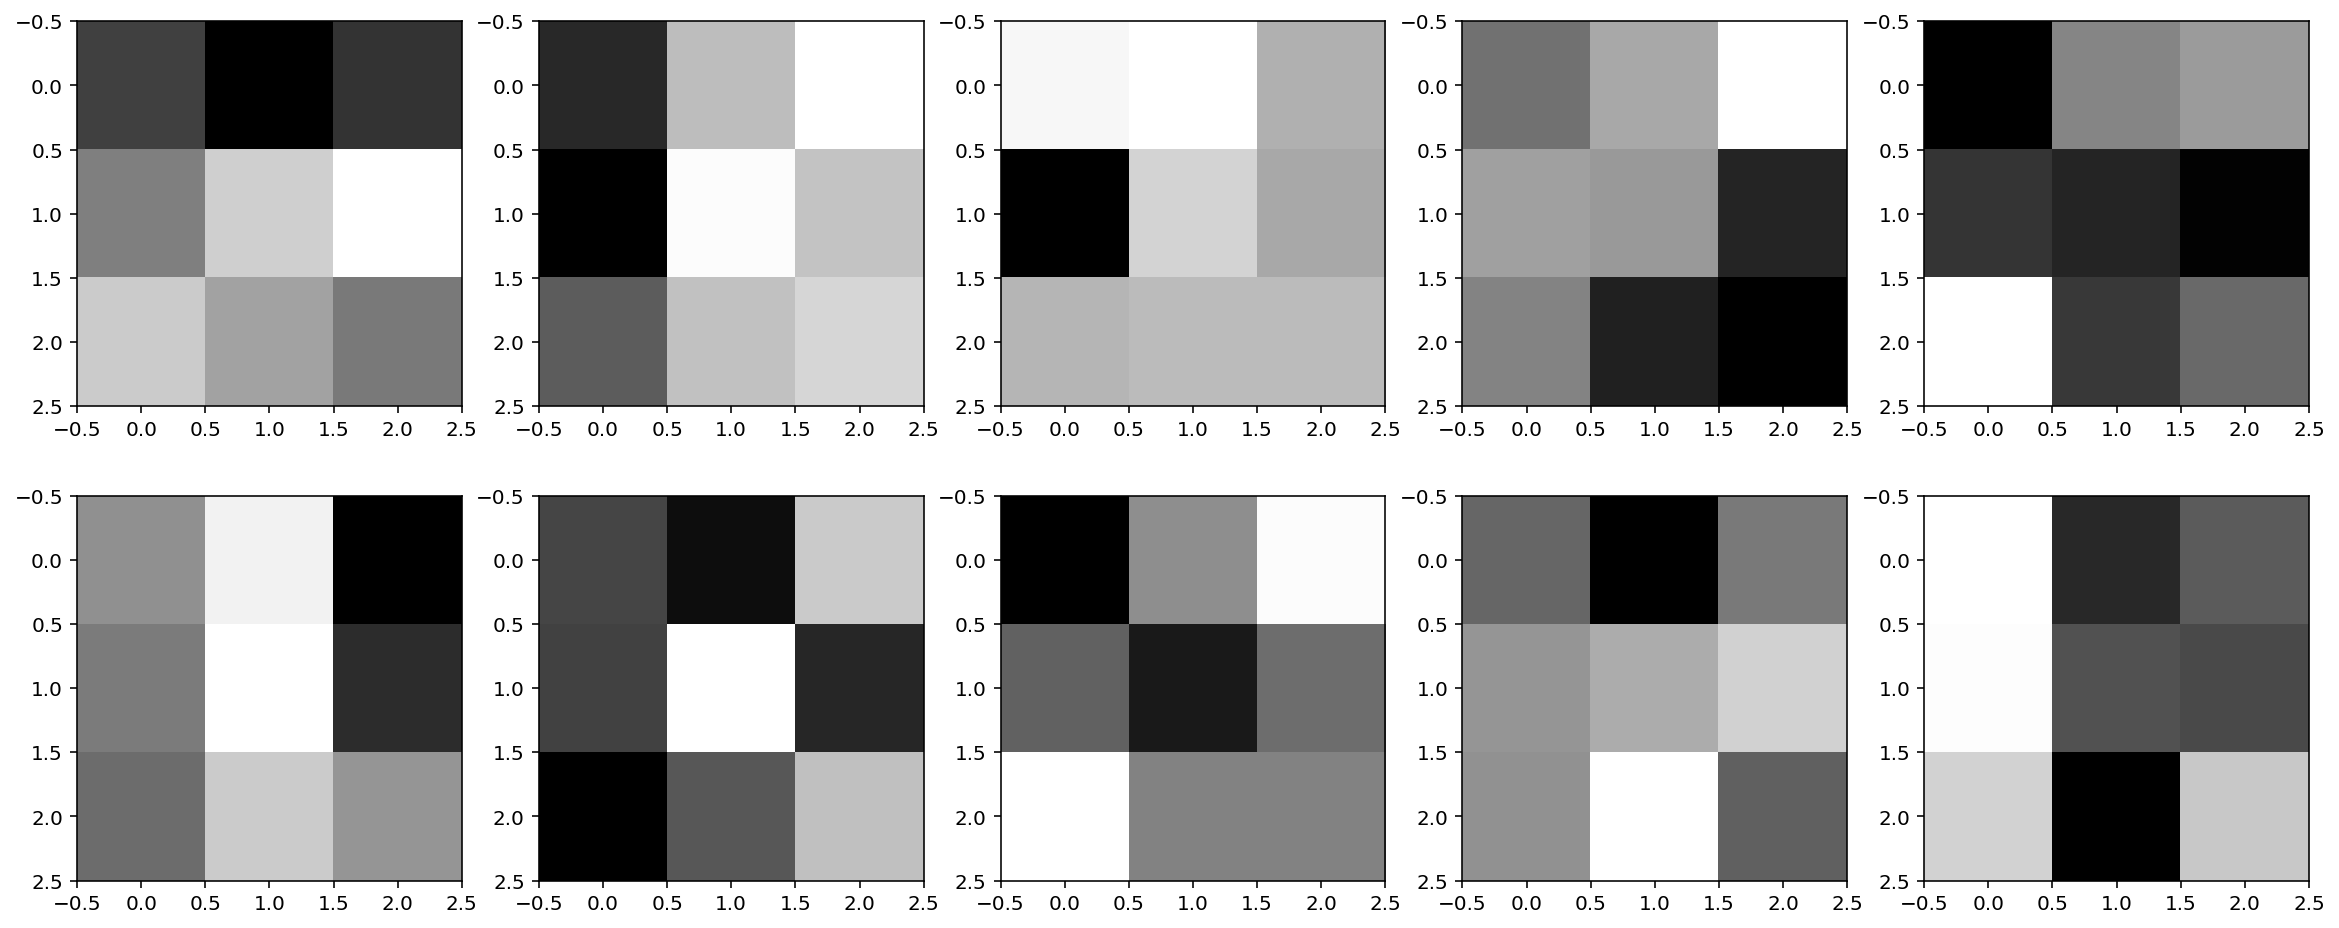

In [31]:
# Get the weights in the first conv layer and convert them to numpy
weights = net.conv1.weight.data
w = weights.numpy()
# for 10 filters: plot 3x3 filter encoded in grayvalues
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
print('First convolutional layer')
plt.show()

### Activation/Feature Map Visualization

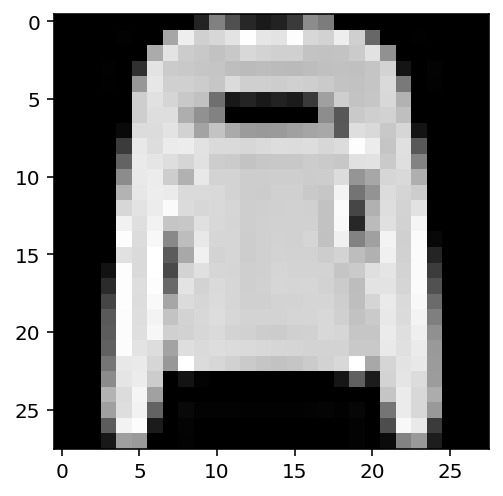

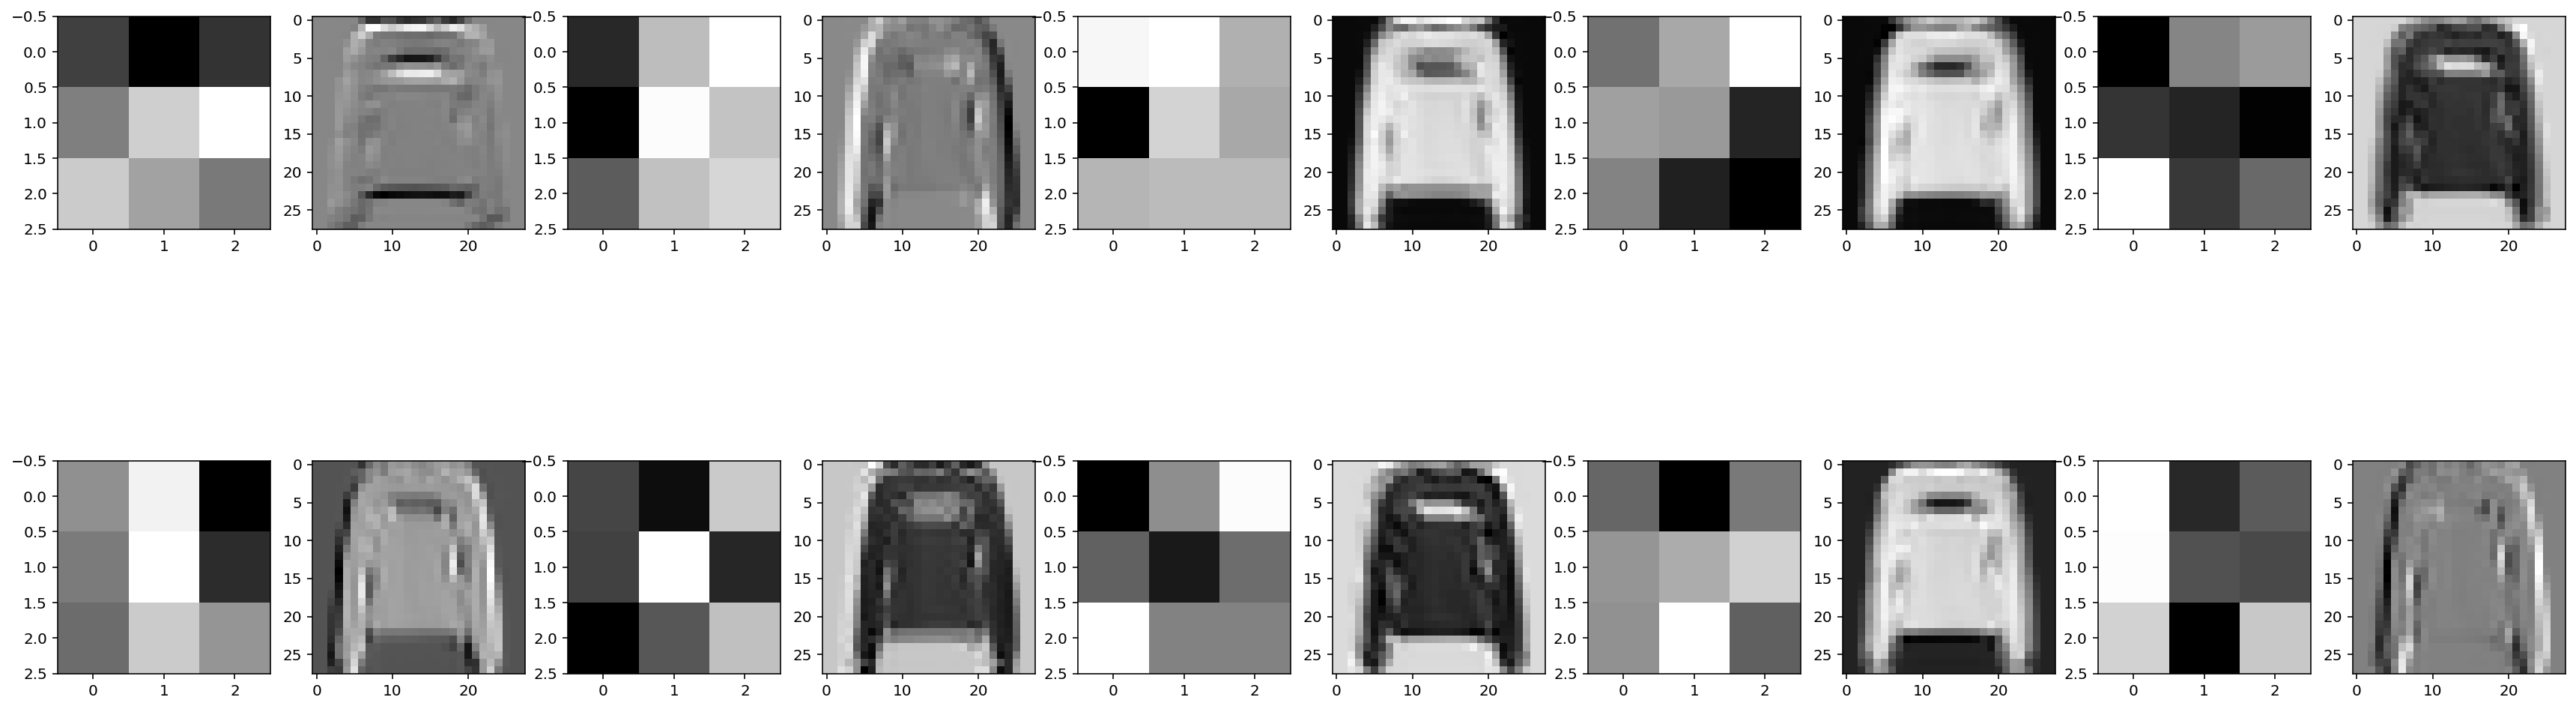

In [32]:
# obtain one batch of testing images
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy()
# select an image by index
idx = 10
img = np.squeeze(images[idx])
# Show image
import cv2
plt.imshow(img, cmap='gray')
# Weights
weights = net.conv1.weight.data
w = weights.numpy()
# First conv layer:
# For 10 filters, use OpenCV's filter2D function:
# Apply a specific set of filter weights (like the one's displayed above) to the test image
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()